In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.15.0


## Prepare Dataset

In [2]:
# train_dataset_path = './dataset/dataset-raw-asli/train_preprocess.tsv'
# valid_dataset_path = './dataset/dataset-raw-asli/valid_preprocess.tsv'

# train_df_path = './dataset/train_all_socialab.csv'
train_df_path = './dataset/indo-nlu-socialabs-merged-new-clean.csv'

# train_dataset_path = './dataset/train_preprocess_no_stemming copy.csv'
# valid_dataset_path = './dataset/valid_preprocess_no_stemming.csv'

In [3]:
# train_df = pd.read_csv(train_dataset_path, sep='\t', header=None)
# valid_df = pd.read_csv(valid_dataset_path, sep='\t', header=None)

# train_df.columns = ['text', 'label']
# valid_df.columns = ['text', 'label']

train_df = pd.read_csv(train_df_path, sep=',', header=None, usecols=[1,2], skiprows=1)

# train_df = pd.read_csv(train_dataset_path, sep=',', header=None, usecols=[1,2], skiprows=1)
# valid_df = pd.read_csv(valid_dataset_path, sep=',', header=None, usecols=[1,2], skiprows=1)

train_df.columns = ['label', 'tweet_tokens_no_stemming']
# valid_df.columns = ['label', 'tweet_tokens_no_stemming']

In [4]:
train_df.head(10)

,label,tweet_tokens_no_stemming
0,positive,"['warung', 'milik', 'usaha', 'pabrik', 'puluh'..."
1,neutral,"['mohon', 'ulama', 'lurus', 'mmbri', 'hujjah',..."
2,positive,"['lokasi', 'strategis', 'jalan', 'sumatera', '..."
3,positive,"['betapa', 'bahagia', 'unboxing', 'paket', 'ba..."
4,negative,"['duh', 'mahasiswa', 'jangan_sombong', 'kasih'..."
5,positive,"['makan', 'agam', 'harga', 'makan', 'food', 's..."
6,negative,"['pakai', 'kartu', 'kredit', 'baca', 'tidak_un..."
7,positive,"['unik', 'bagus', 'foto-foto', 'makan', 'enak'..."
8,positive,"['keluarga', 'nikmat', 'alam', 'kuliner', 'sen..."
9,positive,['syukur']


In [5]:
def get_label_idx(label):
    if label == 'positive':
        return 2
    if label == 'negative':
        return 1
    if label == 'neutral':
        return 0
train_df['label'] = train_df['label'].apply(get_label_idx)
# valid_df['label'] = valid_df['label'].apply(get_label_idx)


In [6]:
train_df

,label,tweet_tokens_no_stemming
0,2,"['warung', 'milik', 'usaha', 'pabrik', 'puluh'..."
1,0,"['mohon', 'ulama', 'lurus', 'mmbri', 'hujjah',..."
2,2,"['lokasi', 'strategis', 'jalan', 'sumatera', '..."
3,2,"['betapa', 'bahagia', 'unboxing', 'paket', 'ba..."
4,1,"['duh', 'mahasiswa', 'jangan_sombong', 'kasih'..."
...,...,...
37941,2,"['suka', 'gayacek', 'olevs', 'jam', 'tangan', ..."
37942,2,"['cod', 'beli', 'euphoria', 'wonderland', 'for..."
37943,2,"['cod', 'flash', 'sale', 'shopee']"
37944,2,"['temu', 'cod', 'light', 'stick', 'treasure', ..."


In [7]:
jumlah_positives = (train_df['label'] == 2).sum()
print(f'Jumlah review positif: {jumlah_positives}')

jumlah_negatives = (train_df['label'] == 1).sum()
print(f'Jumlah review negatif: {jumlah_negatives}')

Jumlah review positif: 18180
Jumlah review negatif: 18487


In [8]:
# join list of token as single document string
import ast

def join_text_list(texts):
    texts = ast.literal_eval(texts)
    return ' '.join([text for text in texts])
train_df["preprocessed"] = train_df["tweet_tokens_no_stemming"].apply(join_text_list)
# valid_df["preprocessed"] = valid_df["tweet_tokens_no_stemming"].apply(join_text_list)

train_df["preprocessed"].head()

0    warung milik usaha pabrik puluh tahun-tahun ke...
1    mohon ulama lurus mmbri hujjah partai apa-apa ...
2    lokasi strategis jalan sumatera bandung nyaman...
3      betapa bahagia unboxing paket barang bagus beli
4    duh mahasiswa jangan_sombong kasih kartu kunin...
Name: preprocessed, dtype: object

In [9]:
# df_preprocessed = pd.DataFrame(train_df['preprocessed'])

In [10]:
# df_preprocessed

# df_preprocessed.to_csv('./dataset/processed.csv', index=False)

In [11]:
# Filter DataFrame untuk label 1 dan 2
df_train_filtered = train_df[train_df['label'].isin([1, 2])]
# df_valid_filtered = valid_df[valid_df['label'].isin([1, 2])]

# Perbarui label sehingga label 1 menjadi 0 dan label 2 menjadi 1
df_train_filtered.loc[:, 'label'] = df_train_filtered['label'].map({1: 0, 2: 1})
# df_valid_filtered.loc[:, 'label'] = df_valid_filtered['label'].map({1: 0, 2: 1})


# Split dataset menjadi fitur (X) dan label (y)
X_train = df_train_filtered['preprocessed']
y_train = df_train_filtered['label']

# X_valid = df_valid_filtered['preprocessed']
# y_valid = df_valid_filtered['label']

In [12]:
## hitung jumlah positive dan negative
jumlah_positives = (y_train == 1).sum()
print(f'Jumlah review positif: {jumlah_positives}')

jumlah_negatives = (y_train == 0).sum()
print(f'Jumlah review negatif: {jumlah_negatives}')

# jumlah_positives = (y_valid == 1).sum()
# print(f'Jumlah review positif: {jumlah_positives}')

# jumlah_negatives = (y_valid == 0).sum()
# print(f'Jumlah review negatif: {jumlah_negatives}')

Jumlah review positif: 18180
Jumlah review negatif: 18487


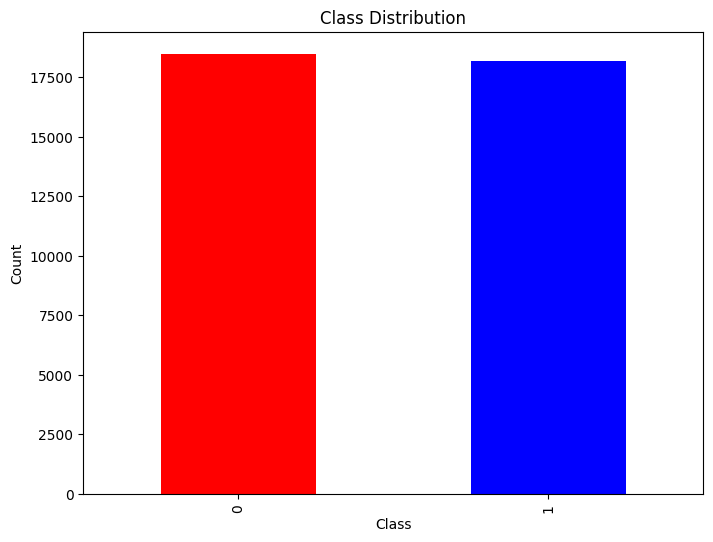

In [13]:
# Mengatur warna per kelas
colors = ['red', 'blue']

# Membuat grafik distribusi kelas dengan warna yang berbeda
plt.figure(figsize=(8, 6))
y_train.value_counts().sort_index().plot(kind='bar', color=colors)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

plt.show()

In [14]:
##split dataset
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train,random_state=42)

Recommended vocab_size: 17890


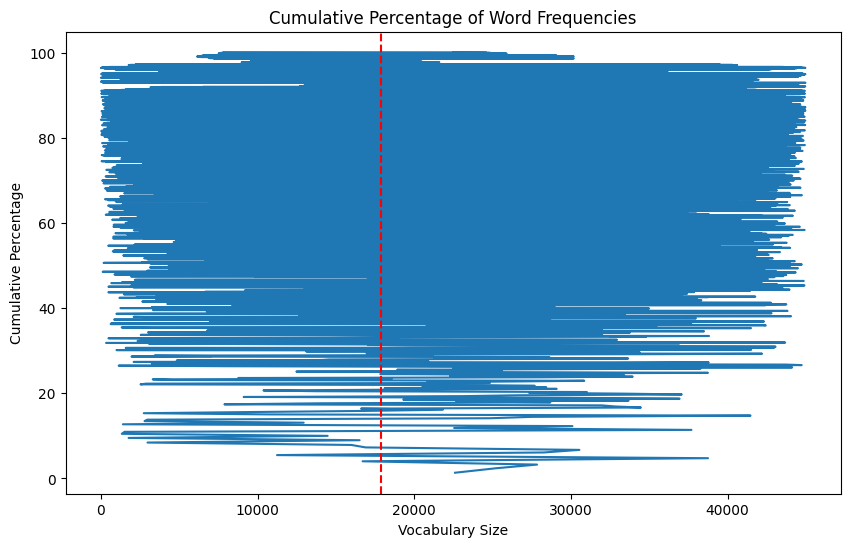

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt

# Gabungkan data pelatihan dan validasi
X_combined = pd.concat([X_train, X_valid])

# Inisialisasi CountVectorizer
vectorizer = CountVectorizer()

# Fit dan transform data teks
X_counts = vectorizer.fit_transform(X_combined)

# Konversi hasil ke dalam DataFrame
word_counts = pd.DataFrame({'word': vectorizer.get_feature_names_out(), 'count': X_counts.sum(axis=0).A1})

# Urutkan berdasarkan frekuensi tertinggi
word_counts = word_counts.sort_values(by='count', ascending=False)

# Hitung total frekuensi kata
total_count = word_counts['count'].sum()

# Hitung persentase kumulatif frekuensi kata
word_counts['cumulative_percentage'] = word_counts['count'].cumsum() / total_count * 100

# Tentukan vocab_size yang mencakup 95% dari total frekuensi kata
vocab_size = np.argmax(word_counts['cumulative_percentage'] > 95) + 1

print(f"Recommended vocab_size: {vocab_size}")

# Visualisasikan persentase kumulatif frekuensi kata
plt.figure(figsize=(10, 6))
plt.plot(word_counts['cumulative_percentage'])
plt.xlabel('Vocabulary Size')
plt.ylabel('Cumulative Percentage')
plt.title('Cumulative Percentage of Word Frequencies')
plt.axvline(vocab_size, color='red', linestyle='--')
plt.show()


## Generate Padded Sequence

In [102]:
# Parameters

vocab_size = 17890 #ukuran kosakata yang akan digunakan
max_length = 50 #panjang maksimal dari sebuah kalimat
embedding_dim = 8 #dimensi vektor embedding yang akan digunakan
trunc_type='post' #jika panjang kalimat melebihi max_length, potong bagian belakang kalimat
oov_tok = "<OOV>" #OOV (Out Of Vocabulary) token, jika suatu kata tidak ditemukan dalam kosakata

In [103]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import re

# Preprocess texts to retain underscore and tokenize specific punctuations
def preprocess_text(text):
    to_tokenize = '.,:;!?'
    return re.sub(r'([' + re.escape(to_tokenize) + '])', r' \1 ', text)

# Apply preprocessing
X_train = [preprocess_text(text) for text in X_train]
X_valid = [preprocess_text(text) for text in X_valid]

# Tokenisasi
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok, filters='!"#$%&()*+-/:;<=>@[\\]^`{|}~\t\n')

# Gabungkan semua teks untuk membuat kamus indeks kata
all_texts = list(X_train) + list(X_valid)

# Membuat kamus indeks kata
tokenizer.fit_on_texts(all_texts)
word_index = tokenizer.word_index
word_index


# Konversi kalimat menjadi urutan kata
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, maxlen=max_length, truncating=trunc_type, padding="post")

valid_sequences = tokenizer.texts_to_sequences(X_valid)
valid_padded = pad_sequences(valid_sequences, maxlen=max_length, truncating=trunc_type, padding="post")




In [132]:
# hitung sequences terpanjang ada berapa
max_sequence_length = max([len(sequence) for sequence in train_sequences])
print(f"Max sequence length: {max_sequence_length}")

# hitung rata rata panjang sequences
avg_sequence_length = np.mean([len(sequence) for sequence in train_sequences] + [len(sequence) for sequence in valid_sequences])
print(f"Average sequence length: {avg_sequence_length}")

Max sequence length: 58
Average sequence length: 14.949900455450406


In [30]:
# df_word_index = pd.DataFrame(word_index.items(), columns=['word', 'index'])

# # Periksa hasil tokenisasi
# print(df_word_index.head(20))

# # Simpan hasil tokenisasi ke file CSV
# df_word_index.to_csv('./dataset/word_index.csv', index=False, sep=',')

         word  index
0       <OOV>      1
1       makan      2
2        milu      3
3       orang      4
4      israel      5
5         the      6
6        enak      7
7   palestina      8
8     politik      9
9         iya     10
10  indonesia     11
11     banget     12
12       iran     13
13        apa     14
14      harga     15
15       anak     16
16      anies     17
17      tahun     18
18       main     19
19      pilih     20


In [41]:
# import pickle

# # Simpan tokenizer ke dalam file
# with open('tokenizer-2classes-stemmed-new.pickle', 'wb') as handle:
#     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [104]:
print(train_padded[12])

[  18   18  197   38  569   38 4421  123   21    1 7291   38 1079    9
  232  197 1244  272   34   38  197    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


## Word Embedding

In [105]:
from gensim.models import Word2Vec

# Gabungkan data pelatihan dan validasi
sentences = [sentence.split() for sentence in X_train] + [sentence.split() for sentence in X_valid]

# Latih model Word2Vec
w2v_model = Word2Vec(sentences, vector_size=8, window=5, min_count=5, workers=4)

In [106]:
# Create a weight matrix for the embedding layer
embedding_matrix = np.zeros((vocab_size, 8))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
        

In [107]:
embedding_matrix.shape

(17890, 8)

In [108]:
# Mencari kata berdasarkan vektor tertentu
def find_word_by_vector(embedding_matrix, vector):
    for word, index in word_index.items():
        if np.array_equal(embedding_matrix[index], vector):
            return word, embedding_matrix[index]
    return None

# Contoh: Mencari kata untuk vektor embedding_matrix[3]
word = find_word_by_vector(embedding_matrix, embedding_matrix[120])
print(word)

('mantap', array([-2.02563095, -0.80485767,  2.28459644, -1.28393817, -1.59697115,
       -0.97854179,  2.95761323,  1.08987117]))


In [220]:
# Apply SMOTE
# from imblearn.over_sampling import SMOTE

# smote = SMOTE(sampling_strategy='minority')

# X_train, y_train = smote.fit_resample(train_padded, y_train)


In [23]:
# # check jumlah kelas
jumlah_positives = (y_valid == 1).sum()

print(f'Jumlah review positif: {jumlah_positives}')

jumlah_negatives = (y_valid == 0).sum()

print(f'Jumlah review negatif: {jumlah_negatives}')

Jumlah review positif: 1818
Jumlah review negatif: 1849


## Build and Compile Model

In [167]:



model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 8,  embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix), input_shape=(max_length,), trainable=False),
    tf.keras.layers.Conv1D(128, 5, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ (None, 50, 8)             │    143,120 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv1d_10 (Conv1D)              │ (None, 50, 128)           │      5,248 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 25, 128)           │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_20 (Dropout)            │ (None, 25, 128)           │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_10 (Flatten)            │ (None, 3200)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_20 (Dense)                │ (None, 16)                │     51,216 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_21 (Dropout)            │ (None, 16)                │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_21 (Dense)                │ (None, 1)                 │         17 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 199,601 (779.69 KB)

 Trainable params: 199,601 (779.69 KB)

 Non-trainable params: 0 (0.00 B)

In [166]:
# Looping untuk mendapatkan bobot dari setiap layer
for layer in model.layers:
    # Mengecek apakah layer memiliki bobot
    if layer.weights:
        print("Layer Name:", layer.name)
        # Mendapatkan bobot dan bias dari layer
        weights = layer.get_weights()
        for i, w in enumerate(weights):
            print("Weights Shape (Tensor {}):".format(i), w.shape)
            print("Weights (Tensor {}):".format(i))
            print(w)


Layer Name: embedding_9
Weights Shape (Tensor 0): (17890, 8)
Weights (Tensor 0):
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-3.2440863   0.83169305  3.5482259  ... -6.4614353   5.293918
   1.2364079 ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
Layer Name: conv1d_9
Weights Shape (Tensor 0): (5, 8, 1)
Weights (Tensor 0):
[[[ 0.34005296]
  [-0.26884115]
  [-0.27239695]
  [ 0.3419689 ]
  [-0.14310506]
  [ 0.14953518]
  [ 0.16592693]
  [-0.24781844]]

 [[-0.13685393]
  [ 0.3558542 ]
  [ 0.16240609]
  [ 0.33218312]
  [ 0.23900187]
  [ 0.14695793]
  [ 0.341524  ]
  [ 0.324803  ]]

 [[ 0.18903148]
  [ 0.03120485]
  [-0.29787904]
  [ 0.0514074 ]
  [-0.19920264]
  [-0.1982323 ]
  [-0.34521186]
  [ 0.01690391]]

 [

## Train Model

In [158]:
num_epochs = 10

history = model.fit(train_padded, y_train, epochs=num_epochs, validation_data=(valid_padded, y_valid))


Epoch 1/10
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 42s 16ms/step - accuracy: 0.7320 - loss: 0.5299 - val_accuracy: 0.8219 - val_loss: 0.4136
Epoch 2/10
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.8144 - loss: 0.4228 - val_accuracy: 0.8397 - val_loss: 0.3751
Epoch 3/10
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.8451 - loss: 0.3809 - val_accuracy: 0.8552 - val_loss: 0.3523
Epoch 4/10
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.8626 - loss: 0.3367 - val_accuracy: 0.8645 - val_loss: 0.3361
Epoch 5/10
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8827 - loss: 0.3024 - val_accuracy: 0.8743 - val_loss: 0.3312
Epoch 6/10
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8992 - loss: 0.2649 - val_accuracy: 0.8732 - val_loss: 0.3216
Epoch 7/10
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9121 - loss: 0.2324 - val_accuracy: 0.8773 - val_loss: 0.3365
Epoch 8/10
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9206 - l

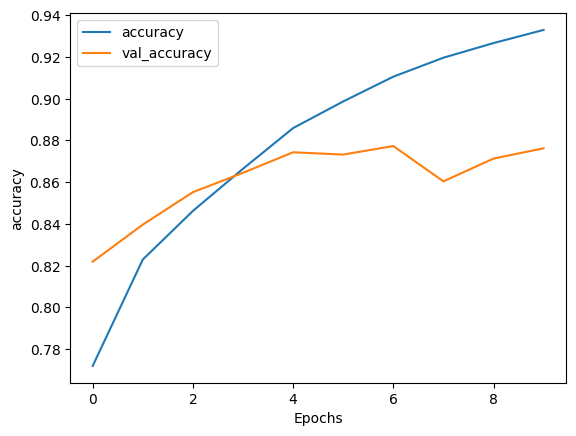

In [159]:
# Plot the training history
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")

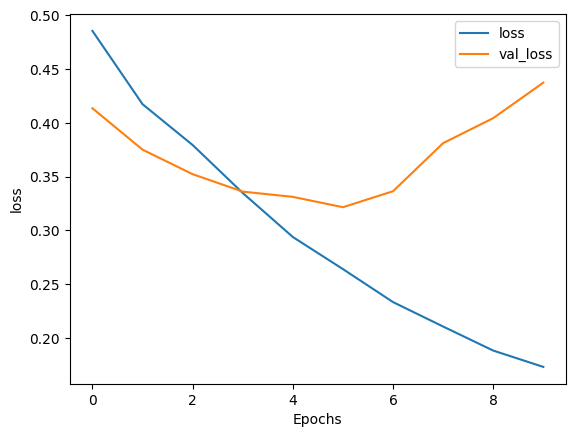

In [160]:
# Plot the training history
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "loss")

In [161]:
def predict_sentiment(model, tokenizer, text):
    # Tokenisasi teks
    sample_seq = tokenizer.texts_to_sequences([text])
    sample_padded = pad_sequences(sample_seq, maxlen=max_length, truncating=trunc_type, padding="post")
    
    # Prediksi sentimen menggunakan model
    prediction = model.predict(sample_padded)
    print(prediction)
    # Mengembalikan label sentimen berdasarkan output model
    if prediction >= 0.5:
        return "Positif"
    else:
        return "Negatif"

# Menggunakan fungsi untuk memprediksi sentimen dari contoh kalimat
sample_text = "rencana bangun infrastruktur wilayah timur sambut baik masyarakat"
predicted_label = predict_sentiment(model, tokenizer, sample_text)
print("Label Sentimen:", predicted_label)
   


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
[[0.99969214]]
Label Sentimen: Positif


In [162]:
from sklearn.metrics import classification_report

# Melakukan prediksi pada data uji
y_pred = model.predict(valid_padded)
y_pred_classes = (y_pred >= 0.5).astype(int)

# Mencetak classification report
# print(classification_report(df_valid_filtered["label"], y_pred_classes))
print(classification_report(y_valid, y_pred_classes))

115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
              precision    recall  f1-score   support

           0       0.87      0.88      0.88      1849
           1       0.88      0.87      0.87      1818

    accuracy                           0.88      3667
   macro avg       0.88      0.88      0.88      3667
weighted avg       0.88      0.88      0.88      3667



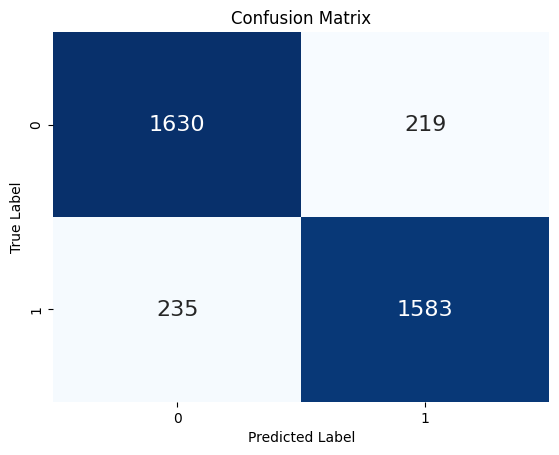

In [163]:
# create a confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Membuat confusion matrix
# cm = confusion_matrix(df_valid_filtered["label"], y_pred_classes)
cm = confusion_matrix(y_valid, y_pred_classes)

# Membuat heatmap dari confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 16})
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [122]:
print(cm)

[[1626  223]
 [ 237 1581]]


In [250]:
# from sklearn.model_selection import KFold
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences

# num_folds = 10


# # Combine training and validation data for K-Fold
# X = np.concatenate((train_padded, valid_padded), axis=0)
# y = np.concatenate((y_train, y_valid), axis=0)

# # K-Fold Cross Validation
# kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# fold_no = 1
# for train_index, valid_index in kf.split(X):
#     print(f'Training fold {fold_no} ... \n ' )

#     # Split data
#     X_train_fold, X_valid_fold = X[train_index], X[valid_index]
#     y_train_fold, y_valid_fold = y[train_index], y[valid_index]

#     # Build the model
#     model_fold = tf.keras.Sequential([
#         tf.keras.layers.Embedding(vocab_size, embedding_dim, input_shape=(max_length,)),
#         tf.keras.layers.Conv1D(128, 5, activation='relu', padding='same'),
#         tf.keras.layers.MaxPooling1D(pool_size=2),
#         tf.keras.layers.Dropout(0.5),
#         tf.keras.layers.Flatten(),
#         tf.keras.layers.Dense(16, activation='relu'),
#         tf.keras.layers.Dropout(0.5),
#         tf.keras.layers.Dense(1, activation='sigmoid')
#     ])

#     model_fold.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#     # Train the model
#     history = model.fit(X_train_fold, y_train_fold, epochs=5, validation_data=(X_valid_fold, y_valid_fold))

#     print(f'Fold {fold_no} completed')

#     fold_no += 1

# # Evaluate the final model on all data (optional)
# final_loss, final_accuracy = model_fold.evaluate(X, y)
# print(f'Final loss: {final_loss}, Final accuracy: {final_accuracy}')


Training fold 1 ... 
 


c:\Users\lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5


ValueError: Cannot take the length of shape with unknown rank.

In [140]:
#save model
model.save('./model/model-cnn-word2vec-2-classes-stemmed-new-32.h5')

In [1124]:
32# import numpy as np
# import tensorflow as tf

# # Inisialisasi bobot kernel dengan ukuran 5
# kernel_size = 5
# num_filters = 1
# embedding_dim = 8

# # Membuat bobot kernel dengan inisialisasi Glorot uniform
# initializer = tf.keras.initializers.GlorotUniform()
# kernel_weights = initializer(shape=(kernel_size, embedding_dim, num_filters))

# # Dibulatkan ke angka terdekat
# kernel_weights_rounded = np.round(kernel_weights, decimals=2)

# print("Bobot kernel dengan inisialisasi Glorot uniform (dibulatkan):")
# print(kernel_weights_rounded)
# print("Shape bobot kernel:", kernel_weights.shape)
